## Subgraph sampling using k-path motif sampling

In [57]:
#Imports
import numpy as np
from NNetwork import NNetwork as nn
import networkx as nx
#import utils.NNetwork as nn
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn import metrics, model_selection
from tqdm import trange
from sklearn.cluster import KMeans
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA ### Use truncated SVD / online PCA later for better computational efficiency
import warnings
warnings.filterwarnings("ignore")

In [2]:
def display_graphs(title,
                     save_path,
                     grid_shape=[2,3],
                     fig_size=[10,10],
                     data = None, # [X, embs]
                     show_importance=False):

        # columns of X = vectorized k x k adjacency matrices
        # corresponding list in embs = sequence of nodes (may overalp)
        X, embs = data
        print('X.shape', X.shape)

        rows = grid_shape[0]
        cols = grid_shape[1]

        fig = plt.figure(figsize=fig_size, constrained_layout=False)
        # make outer gridspec

        idx = np.arange(X.shape[1])
        outer_grid = gridspec.GridSpec(nrows=rows, ncols=cols, wspace=0.02, hspace=0.02)

        # make nested gridspecs
        for i in range(rows * cols):
            a = i // cols
            b = i % rows

            Ndict_wspace = 0.05
            Ndict_hspace = 0.05

            # display graphs
            inner_grid = outer_grid[i].subgridspec(1, 1, wspace=Ndict_wspace, hspace=Ndict_hspace)

            # get rid of duplicate nodes
            A = X[:,idx[i]]
            A = X[:,idx[i]].reshape(int(np.sqrt(X.shape[0])), -1)
            H = nn.NNetwork()
            H.read_adj(A, embs[idx[i]])
            A_sub = H.get_adjacency_matrix()

            # read in as a nx graph for plotting
            G1 = nx.from_numpy_matrix(A_sub)
            ax = fig.add_subplot(inner_grid[0, 0])
            pos = nx.spring_layout(G1)
            edges = G1.edges()
            weights = [1*G1[u][v]['weight'] for u,v in edges]
            nx.draw(G1, with_labels=False, node_size=20, ax=ax, width=weights, label='Graph')

            ax.set_xticks([])
            ax.set_yticks([])

        plt.suptitle(title, fontsize=15)
        fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0)
        fig.savefig(save_path, bbox_inches='tight')

In [3]:
def display_dict_and_graph(title,
                           W, 
                           singular_values, 
                           save_path,
                           grid_shape=None,
                           fig_size=[10,10],
                           show_importance=False,
                           only_show_matrices=True):
        
        n_components = W.shape[1]
        k = int(np.sqrt(W.shape[0]))

        rows = np.round(np.sqrt(n_components))
        rows = rows.astype(int)
        if grid_shape is not None:
            rows = grid_shape[0]
            cols = grid_shape[1]
        else:
            if rows ** 2 == n_components:
                cols = rows
            else:
                cols = rows + 1

        if show_importance:
            # importance = np.sum(self.code, axis=1) / sum(sum(self.code))
            idx = np.argsort(singular_values)
            idx = np.flip(idx)
        else:
            idx = np.arange(W.shape[1])

        Ndict_wspace = 0.05
        Ndict_hspace = 0.05

        fig = plt.figure(figsize=fig_size, constrained_layout=False)
        ncols = 2 
        if only_show_matrices:
            ncols = 1
        outer_grid = gridspec.GridSpec(nrows=1, ncols=ncols, wspace=0.02, hspace=0.02)
        for t in np.arange(2):
            # make nested gridspecs

            if t == 0:
                ### Make gridspec
                inner_grid = outer_grid[t].subgridspec(rows, cols, wspace=Ndict_wspace, hspace=Ndict_hspace)
                #gs1 = fig.add_gridspec(nrows=rows, ncols=cols, wspace=0.05, hspace=0.05)

                for i in range(rows * cols):
                    a = i // cols
                    b = i % cols
                    ax = fig.add_subplot(inner_grid[a, b])
                    ax.imshow(W.T[idx[i]].reshape(k, k), cmap="viridis", interpolation='nearest')
                    # ax.set_xlabel('%1.2f' % importance[idx[i]], fontsize=13)  # get the largest first
                    # ax.xaxis.set_label_coords(0.5, -0.05)  # adjust location of importance appearing beneath patches
                    ax.set_xticks([])
                    ax.set_yticks([])
            if (t == 1) and not only_show_matrices:
                inner_grid = outer_grid[t].subgridspec(rows, cols, wspace=Ndict_wspace, hspace=Ndict_hspace)
                #gs1 = fig.add_gridspec(nrows=rows, ncols=cols, wspace=0.05, hspace=0.05)

                for i in range(rows * cols):
                    a = i // cols
                    b = i % cols

                    G1 = nx.from_numpy_matrix(W[:,idx[i]].reshape(int(np.sqrt(W.shape[0])),-1))
                    ax = fig.add_subplot(inner_grid[a, b])
                    pos = nx.spring_layout(G1)
                    edges = G1.edges()
                    weights = [2*G1[u][v]['weight'] for u,v in edges]
                    nx.draw(G1, with_labels=False, node_size=10, ax=ax, width=weights, label='Graph')
                    if show_importance:
                        ax.set_xlabel('%1.2f' % importance[idx[i]], fontsize=13)  # get the largest first
                        ax.xaxis.set_label_coords(0.5, -0.05)  # adjust location of importance appearing beneath patches

                    ax.set_xticks([])
                    ax.set_yticks([])

        if title is not None:
            plt.suptitle(title, fontsize=25)
        fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0)
        fig.savefig(save_path, bbox_inches='tight')

In [4]:
sampling_alg = 'pivot'

ntwk = 'Caltech36' # COVID_PPI, Wisconsin87, UCLA26
ntwk_nonumber = ''.join([i for i in ntwk if not i.isdigit()])
save_folder = 'Subgraph_sampling/test1/'
k=20

path = "Data/Networks_all_NDL/" + str(ntwk) + '.txt'
G = nn.NNetwork()
G.load_add_edges(path, increment_weights=False, use_genfromtxt=True)
print('num nodes in G', len(G.nodes()))
print('num edges in G', len(G.get_edges()))

#mx0 = G.get_adjacency_matrix(ordered_node_list=G.nodes())
#plt.imshow(mx0)

num nodes in G 769
num edges in G 33312


num of subgraphs induced on k-paths: 10000
X.shape (400, 10000)


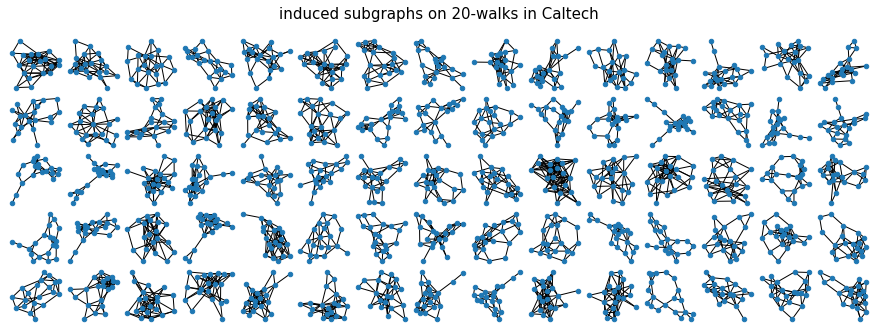

In [5]:
X, embs = G.get_patches(k=k, sample_size=10000, skip_folded_hom=True)

display_graphs(title='induced subgraphs on {}-walks in {}'.format(k, ntwk_nonumber),
                 save_path=save_folder + ntwk_nonumber + "_subgraphs_"+ str(sampling_alg) + "_walk", 
                 data = [X, embs],
                 grid_shape = [5, 15],
                 fig_size = [15, 5],
                 show_importance=False)

## NMF experiments

In [42]:
def coding(X, W, H0, 
          r=None, 
          a1=0, #L1 regularizer
          a2=0, #L2 regularizer
          sub_iter=[5], 
          stopping_grad_ratio=0.0001, 
          nonnegativity=True,
          subsample_ratio=1):
    """
    Find \hat{H} = argmin_H ( || X - WH||_{F}^2 + a1*|H| + a2*|H|_{F}^{2} ) within radius r from H0
    Use row-wise projected gradient descent
    """
    H1 = H0.copy()
    i = 0
    dist = 1
    idx = np.arange(X.shape[1])
    if subsample_ratio>1:  # subsample columns of X and solve reduced problem (like in SGD)
        idx = np.random.randint(X.shape[1], size=X.shape[1]//subsample_ratio)
    A = W.T @ W ## Needed for gradient computation
    grad = W.T @ (W @ H0 - X)
    while (i < np.random.choice(sub_iter)):
        step_size = (1 / (((i + 1) ** (1)) * (np.trace(A) + 1)))
        H1 -= step_size * grad 
        if nonnegativity:
            H1 = np.maximum(H1, 0)  # nonnegativity constraint
        i = i + 1
    return H1


def ALS(X,
        n_components = 10, # number of columns in the dictionary matrix W
        n_iter=100,
        a0 = 0, # L1 regularizer for H
        a1 = 0, # L1 regularizer for W
        a12 = 0, # L2 regularizer for W
        H_nonnegativity=True,
        W_nonnegativity=True,
        compute_recons_error=False,
        subsample_ratio = 10):
    
        '''
        Given data matrix X, use alternating least squares to find factors W,H so that 
                                || X - WH ||_{F}^2 + a0*|H|_{1} + a1*|W|_{1} + a12 * |W|_{F}^{2}
        is minimized (at least locally)
        '''
        
        d, n = X.shape
        r = n_components
        
        #normalization = np.linalg.norm(X.reshape(-1,1),1)/np.product(X.shape) # avg entry of X
        #print('!!! avg entry of X', normalization)
        #X = X/normalization

        # Initialize factors 
        W = np.random.rand(d,r)
        H = np.random.rand(r,n) 
        # H = H * np.linalg.norm(X) / np.linalg.norm(H)
        for i in trange(n_iter):
            #H = coding_within_radius(X, W.copy(), H.copy(), a1=a0, nonnegativity=H_nonnegativity, subsample_ratio=subsample_ratio)
            #W = coding_within_radius(X.T, H.copy().T, W.copy().T, a1=a1, a2=a12, nonnegativity=W_nonnegativity, subsample_ratio=subsample_ratio).T
            H = coding(X, W.copy(), H.copy(), a1=a0, nonnegativity=H_nonnegativity, subsample_ratio=subsample_ratio)
            W = coding(X.T, H.copy().T, W.copy().T, a1=a1, a2=a12, nonnegativity=W_nonnegativity, subsample_ratio=subsample_ratio).T
            W /= np.linalg.norm(W)
            if compute_recons_error and (i % 10 == 0) :
                print('iteration %i, reconstruction error %f' % (i, np.linalg.norm(X-W@H)**2))
        return W, H


def display_dictionary(W, save_name=None, score=None, grid_shape=None, figsize=[10,10]):
    k = int(np.sqrt(W.shape[0]))
    rows = int(np.sqrt(W.shape[1]))
    cols = int(np.sqrt(W.shape[1]))
    if grid_shape is not None:
        rows = grid_shape[0]
        cols = grid_shape[1]
    
    figsize0=figsize
    if (score is None) and (grid_shape is not None):
        figsize0=(cols, rows)
    if (score is not None) and (grid_shape is not None):
        figsize0=(cols, rows+0.2)
    
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=figsize0,
                            subplot_kw={'xticks': [], 'yticks': []})
        
        
    for ax, i in zip(axs.flat, range(100)):
        if score is not None:
            idx = np.argsort(score)
            idx = np.flip(idx)    
            
            ax.imshow(W.T[idx[i]].reshape(k, k), cmap="viridis", interpolation='nearest')
            ax.set_xlabel('%1.2f' % score[i], fontsize=13)  # get the largest first
            ax.xaxis.set_label_coords(0.5, -0.05)
        else: 
            ax.imshow(W.T[i].reshape(k, k), cmap="viridis", interpolation='nearest')
            if score is not None:
                ax.set_xlabel('%1.2f' % score[i], fontsize=13)  # get the largest first
                ax.xaxis.set_label_coords(0.5, -0.05)
       
    plt.tight_layout()
    # plt.suptitle('Dictionary learned from patches of size %d' % k, fontsize=16)
    plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
    
    if save_name is not None:
        plt.savefig( save_name, bbox_inches='tight')
    plt.show()

In [52]:
# Applying NMF on X
W, H = ALS(X=X, 
           n_components=16, # Reconstruction Error reduces as n_components increases
           n_iter=100, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity=True,
           W_nonnegativity=True,
           compute_recons_error=True,
           subsample_ratio=1)

  5%|██▏                                        | 5/100 [00:00<00:04, 22.39it/s]

iteration 0, reconstruction error 1000598.061213


 15%|██████▎                                   | 15/100 [00:00<00:03, 24.89it/s]

iteration 10, reconstruction error 534628.341259


 24%|██████████                                | 24/100 [00:00<00:02, 25.96it/s]

iteration 20, reconstruction error 484328.783774


 36%|███████████████                           | 36/100 [00:01<00:02, 24.76it/s]

iteration 30, reconstruction error 453537.272746


 45%|██████████████████▉                       | 45/100 [00:01<00:02, 23.94it/s]

iteration 40, reconstruction error 436434.462468


 54%|██████████████████████▋                   | 54/100 [00:02<00:02, 20.76it/s]

iteration 50, reconstruction error 426377.696336


 62%|██████████████████████████                | 62/100 [00:03<00:03, 12.57it/s]

iteration 60, reconstruction error 420348.514199


 73%|██████████████████████████████▋           | 73/100 [00:03<00:01, 21.46it/s]

iteration 70, reconstruction error 416572.958964


 87%|████████████████████████████████████▌     | 87/100 [00:03<00:00, 27.02it/s]

iteration 80, reconstruction error 414081.743416


 97%|████████████████████████████████████████▋ | 97/100 [00:04<00:00, 28.25it/s]

iteration 90, reconstruction error 412326.355531


100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 22.95it/s]


In [53]:
print(f"Shape of W: {W.shape}\nShape of H: {H.shape}")

Shape of W: (400, 16)
Shape of H: (16, 10000)


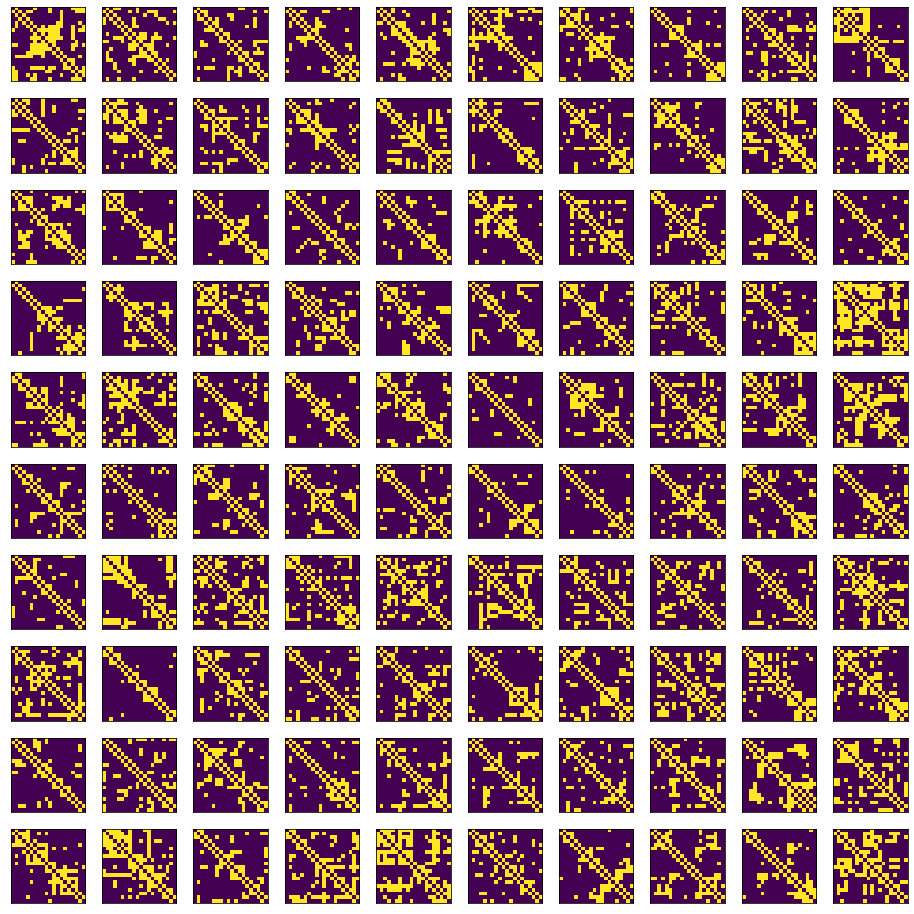

In [54]:
display_dictionary(X[:,:100], figsize=[15,15])

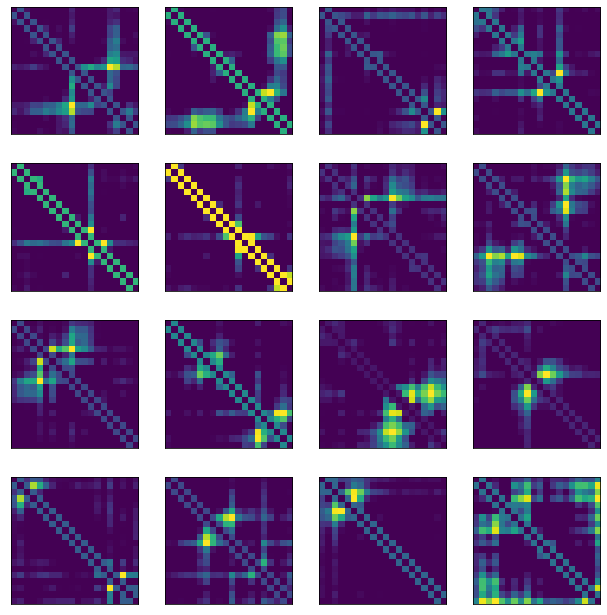

In [55]:
display_dictionary(W, figsize=[10,10])

## NDL after random permutation of node labels

In [66]:
def permute_node_ordering(X):
    # columns of X are vectorized adjacency matrix of k node subgraphs
    Y = X.copy()
    k = int(np.sqrt(X.shape[0])) # number of nodes in each subgraph
    for i in np.arange(X.shape[1]):
        a = X[:,i].reshape(k,k)
        G_nx = nx.from_numpy_matrix(a)
        idx = np.random.choice(np.arange(k), k, replace=False)
        b = nx.adjacency_matrix(G_nx, idx)
        c = b.todense() # permuted adjacency matrix
        Y[:,i] = c.reshape(-1, )
    print('Y.shape', Y.shape)
    return Y

In [67]:
Y = permute_node_ordering(X)

Y.shape (400, 10000)


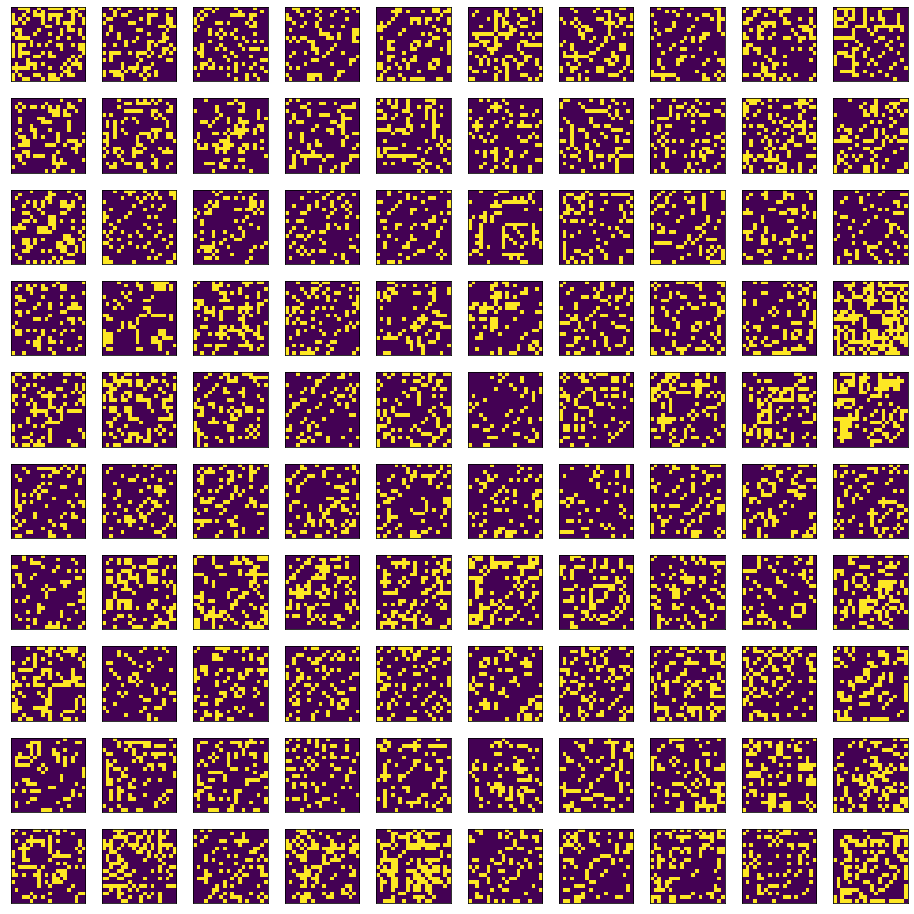

In [68]:
display_dictionary(Y[:,:100], figsize=[15,15])

In [62]:
W1, H1 = ALS(X=Y, 
           n_components=16, # Reconstruction Error reduces as n_components increases
           n_iter=100, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity=True,
           W_nonnegativity=True,
           compute_recons_error=True,
           subsample_ratio=1)

  5%|██▏                                        | 5/100 [00:00<00:04, 21.84it/s]

iteration 0, reconstruction error 1002119.435865


 14%|█████▉                                    | 14/100 [00:00<00:03, 22.18it/s]

iteration 10, reconstruction error 724295.088334


 26%|██████████▉                               | 26/100 [00:01<00:02, 25.04it/s]

iteration 20, reconstruction error 693544.389748


 35%|██████████████▋                           | 35/100 [00:01<00:02, 26.26it/s]

iteration 30, reconstruction error 681007.076541


 41%|█████████████████▏                        | 41/100 [00:01<00:02, 27.21it/s]

iteration 40, reconstruction error 674681.991765


 56%|███████████████████████▌                  | 56/100 [00:02<00:01, 26.29it/s]

iteration 50, reconstruction error 670928.178103


 66%|███████████████████████████▋              | 66/100 [00:02<00:01, 27.49it/s]

iteration 60, reconstruction error 668313.776196


 76%|███████████████████████████████▉          | 76/100 [00:03<00:00, 29.64it/s]

iteration 70, reconstruction error 666268.952161


 86%|████████████████████████████████████      | 86/100 [00:03<00:00, 29.29it/s]

iteration 80, reconstruction error 664545.058962


 96%|████████████████████████████████████████▎ | 96/100 [00:03<00:00, 29.20it/s]

iteration 90, reconstruction error 663019.946396


100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 26.11it/s]


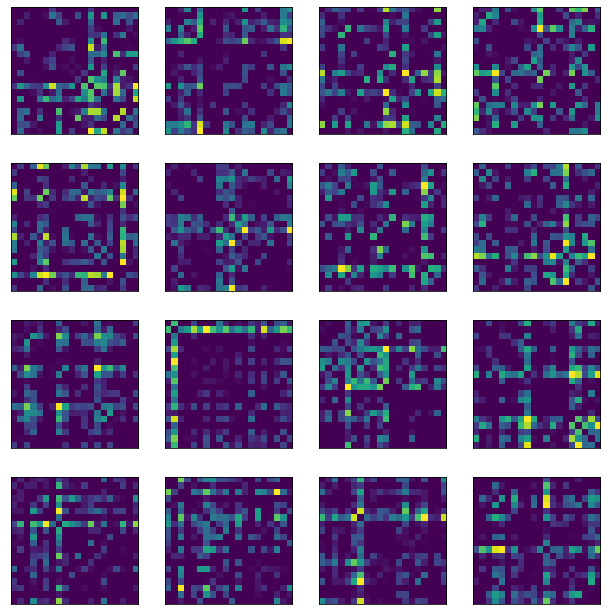

In [63]:
display_dictionary(W1, figsize=[10,10])

## Alternative sampling algorithm using random walks 

In [86]:
#X, embs = G.get_patches(k=k, sample_size=1000, skip_folded_hom=True)

In [93]:
H = G.k_node_ind_subgraph(k=20)

In [94]:
a = H.get_adjacency_matrix()

In [95]:
a.shape

(20, 20)

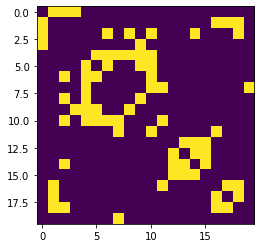

In [96]:
plt.imshow(a)